In [1]:
import world
import agents
from ff import Solved
import ff
import pddl_functions

In [2]:
import block_plotting

In [2]:
print(block_plotting.filter_tower_locations(['o1', 'o2', 'o3', 't1'], get_locations=True))
print(block_plotting.filter_tower_locations(['o1', 'o2', 'o3', 't1'], get_locations=False))

['t1']
['o1', 'o2', 'o3']


In [3]:
w = world.PDDLWorld('blocks-domain.pddl', 'pddl/blocks_problem_colour1.pddl')
agent = agents.CorrectingAgent(w)

Parsing domain blocks-domain.pddl
Parsing problem pddl/blocks_problem_colour1.pddl


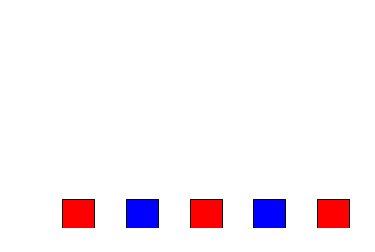

In [4]:
w.draw()


In [3]:
g = w.problem.goal
rule = g.subformulas[0]
or_ = rule.subformulas[0]
exists = or_.subformulas[1]
exists.variables

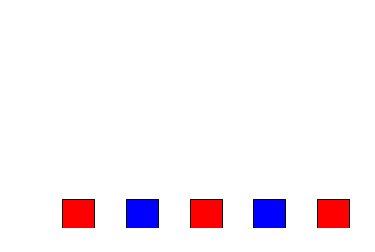

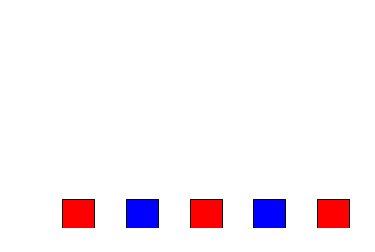

NameError: name 'teacher_correction' is not defined

In [5]:
w.draw()
while not w.test_success():

    plan = agent.plan()
    for a, args in plan:
        w.update(a, args)
        w.draw()
        correction = teacher_correction(a, args, w)
        if correction:
            agent.get_correction(correction, a, args)
            w.draw()
            break
        else:
            agent.no_correction(a, args)
            
print('DONE')    

In [139]:
def teacher_correction( w):
    if not w.test_failure():
        return ""
    #Reasons for failure:
    # a->b, a -b 
    # b-> a b -a
    rules = list(get_rules(w.problem.goal))
    for r in rules:
        if check_rule_violated(r, w):
            print(r.asPDDL())
            c1, c2, _ = get_relevant_colours(r)
            return tower_correction(c1, c2)
    for r in rules:
        o3 = check_table_rule_violation(r, w)
        if o3:
            c1, c2, _ = get_relevant_colours(r)
            return table_correction(c1, c2, o3)
    

In [140]:
teacher_correction(w)


ff: parsing domain file
domain 'BLOCKSWORLD' defined
 ... done.
ff: parsing problem file
problem 'BLOCKS-1' defined
 ... done.



Cueing down from goal distance:    8 into depth [1]
                                   6            [1]
                                   3            [1]

Enforced Hill-climbing failed !
switching to Best-first Search now.

advancing to distance :    8
                           4
                           3

best first search space empty! problem proven unsolvable.



time spent:    0.00 seconds instantiating 36 easy, 0 hard action templates
               0.00 seconds reachability analysis, yielding 37 facts and 28 actions
               0.00 seconds creating final representation with 34 relevant facts
               0.00 seconds building connectivity graph
               0.00 seconds searching, evaluating 92 states, to a max depth of 1
               0.00 seconds total time




'No, now you cannot put b1 in the tower because you must put red blocks on blue blocks'

In [7]:
def tower_correction(obj1, obj2):
    return "no, put {} blocks on {} blocks".format(obj1, obj2)

def table_correction(obj1, obj2, obj3):
    return "No, now you cannot put {} in the tower because you must put {} blocks on {} blocks".format(obj3, obj1, obj2)

In [8]:
def get_top_two(world_):
    r = world_.sense().relations
    for o in r.keys():
        if 'clear' in r[o] and 'in-tower' in r[o]:
            o1 = o
    on = r[o1]['on']
    o2 = on.args.args[1].arg_name
    return o1, o2
get_top_two(w)

('b6', 'b4')

In [18]:
def get_rules(goal):
    for f in goal.subformulas:
        if "in-tower" not in f.asPDDL():
            yield f
            
rule = list(get_rules(w.problem.goal))[0]

In [87]:
def get_name(formula):
    return formula.get_predicates(True)[0].name

def get_args(formula):
    return list(map(lambda x: x.arg_name, formula.get_predicates(True)[0].args.args))

In [95]:
def get_relevant_colours(rule):
    or_ = rule.subformulas[0]
    r1, r2 = or_.subformulas
    colour1 = (r1.subformulas[0])
    colour2 = (list(filter(lambda x: get_name(x) != 'on', r2.subformulas[0].subformulas))[0])
    on = list(filter(lambda x: get_name(x) == 'on', r2.subformulas[0].subformulas))[0]
    o1, o2 = on.get_predicates(True)[0].args.args
    out = (o1, o2)
    c1 = list(filter(lambda x: get_args(x)[0] == o1.arg_name, [colour1, colour2]))[0]
    c2 = list(filter(lambda x: get_args(x)[0] == o2.arg_name, [colour1, colour2]))[0]
    return get_name(c1), get_name(c2), get_name(colour1) # on(c1, c2) colour1 -> colour2
colours = get_relevant_colours(rule)
colours

('red', 'blue', 'red')

In [105]:
def check_rule_violated(rule, world_):
    c1, c2, impl = get_relevant_colours(rule)
    o1, o2 = get_top_two(world_)
    state = world_.problem.initialstate
    f1 = pddl_functions.create_formula(c1, [o1])
    f2 = pddl_functions.create_formula(c2, [o2])
    c1_o1 = pddl_functions.predicate_holds(f1.get_predicates(True)[0], state)
    c2_o2 = pddl_functions.predicate_holds(f2.get_predicates(True)[0], state)
    if c1_o1 and not c2_o2 and c1 == impl:
        return True
    if not c1_o1 and c2_o2 and c2 == impl:
        return True
    return False
    
check_rule_violated(rule, w)



False

In [119]:
def check_table_rule_violation(rule, world_):
    c1, c2, impl = get_relevant_colours(rule)
    o1, o2 = get_top_two(world_)
    state = world_.problem.initialstate
    f1 = pddl_functions.create_formula(c1, [o1])
    f2 = pddl_functions.create_formula(c2, [o2])
    c1_o1 = pddl_functions.predicate_holds(f1.get_predicates(True)[0], state)
    c2_o2 = pddl_functions.predicate_holds(f2.get_predicates(True)[0], state)
    table_objs = blocks_on_table(world_)
    c1_count = count_coloured_blocks(c1, table_objs, state)
    c2_count = count_coloured_blocks(c2, table_objs, state)
    if not c1_o1 and c2_o2 and c1 == impl: 
        if c1_count > c2_count:
            return get_block_with_colour(c1, table_objs, state)
    if c1_o1 and not c2_o2 and c2 == impl:
        if c2_count > c1_count:
            return get_block_with_colour(c2, table_objs, state)
    return False

In [116]:
def blocks_on_table(world_):
    r = world_.sense().relations
    objs = []
    for o in r.keys():
        if 'on-table' in r[o] and 'clear' in r[o]:
            objs.append(o)
    return objs
objs = blocks_on_table(w)
objs

['b1', 'b2', 'b3', 'b5']

In [115]:
def count_coloured_blocks(colour, objects, state):
    count = 0
    for o in objects:
        c_o = pddl_functions.create_formula(colour, [o]).get_predicates(True)[0]
        if pddl_functions.predicate_holds(c_o, state):
            count += 1
    return count

print(count_coloured_blocks('blue', objs, w.problem.initialstate), 1)
print(count_coloured_blocks('red', objs, w.problem.initialstate), 3)

1 1
3 3


In [118]:
def get_block_with_colour(colour, objects, state):
    for o in objects:
        c_o = pddl_functions.create_formula(colour, [o]).get_predicates(True)[0]
        if pddl_functions.predicate_holds(c_o, state):
            return o
    return

In [82]:
c = colours[0]
c = c.get_predicates(True)[0]
c.args.args[0].arg_name

'?x'

In [88]:
get_args(colours[0])

['?x']

In [39]:
import goal_updates
goal_updates.create_goal(['red'], ['blue']).asPDDL()

'(forall (?x) (or (not (red ?x)) (exists (?y) (and (blue ?y) (on ?x ?y)))))'